In [1]:
import pandas as pd
import numpy as np
import json
import os
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
from sklearn.ensemble import RandomForestRegressor
import warnings

In [ ]:
#pip install skforecast

In [2]:
path = os.getcwd()
path = path.replace("\\", "\\\\")
path = path.replace("\\\\", "/")
path_data = "/".join(path.split("/")[:-1]) + "/Data/"
path_est = path_data + "Estandarizada/"

In [59]:
df = pd.read_csv(path_est + "data_refined.csv", keep_default_na=False, na_values="", sep=',')
df['FECHA'] = pd.to_datetime(df.FECHA).dt.to_period('m')

In [60]:
df = df[df['PROVINCIA'] == 'MADRID']
df = df.drop(columns=['PROVINCIA'])

In [61]:
df.shape

(38, 10)

In [54]:
#Crear un objeto FeatureHasher
fh = FeatureHasher(n_features=5, input_type='string')
#Transformar la variable categórica utilizando la codificación Hashing
hashed = fh.transform(df['PROVINCIA'])
#Convertir el resultado en un dataframe
hashed_df = pd.DataFrame(hashed.toarray())
#Unir el dataframe original con el dataframe de características codificadas
df = pd.concat([df, hashed_df], axis=1)
df = df.drop(columns=['PROVINCIA'])

In [62]:
df['FECHA'] = df['FECHA'].astype(str)
df['FECHA'] = pd.to_datetime(df['FECHA'], format='%Y/%m/%d')
df = df.set_index('FECHA')
df = df.asfreq('MS')
df = df.sort_index()
df.head()

,ALTITUD,TEMP_MED,PREC,DIR,VEL_MEDIA,RACHA,PRES_MIN,SOL,TASA_INCIDENCIA
FECHA,,,,,,,,,
2020-01-01,609.0,6.622581,0.400000,32.225806,2.474194,8.609677,955.351613,4.193548,0.02
2020-02-01,609.0,9.817241,0.003448,52.103448,2.189655,7.410345,955.993103,5.644828,0.31
2020-03-01,609.0,11.132258,2.132258,47.677419,3.558065,10.351613,946.696774,5.248387,619.46
2020-04-01,609.0,13.910000,2.386667,38.166667,2.863333,9.810000,945.516667,5.090000,373.31
2020-05-01,609.0,19.454839,1.741935,41.000000,3.038710,10.329032,947.235484,9.309677,79.44


In [63]:
df.shape

(38, 9)

Fechas train : 2020-01-01 00:00:00 --- 2022-02-01 00:00:00  (n=26)
Fechas test  : 2022-03-01 00:00:00 --- 2023-02-01 00:00:00  (n=12)


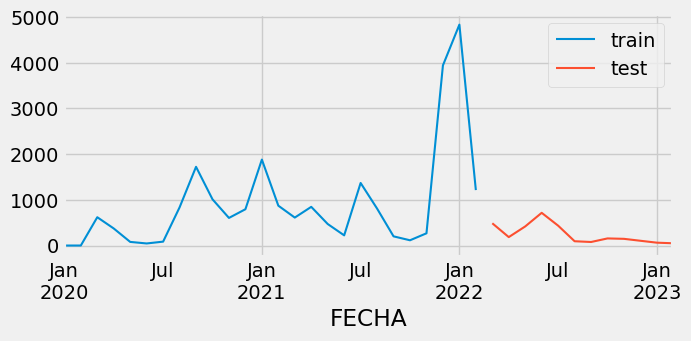

In [95]:
steps = 12
datos_train = df[:-steps]
datos_test  = df[-steps:]
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(7, 3))
datos_train['TASA_INCIDENCIA'].plot(ax=ax, label='train')
datos_test['TASA_INCIDENCIA'].plot(ax=ax, label='test')
ax.legend();

In [96]:
# Crear y entrenar forecaster
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=112),
                lags = 6
             )

forecaster.fit(y=datos_train['TASA_INCIDENCIA'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=112) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2020-01-01 00:00:00'), Timestamp('2022-02-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 112, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-04-24 20:11:51 
Last fit date: 2023-04-24 20:11:51 
Skforecast version: 0.7.0 
Python version: 3.9.13 
Forecaster id: None 

In [97]:
steps = 12
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

2022-03-01     846.9604
2022-04-01    1091.5510
2022-05-01    1325.6643
2022-06-01    1104.6592
2022-07-01    1151.7853
Freq: MS, Name: pred, dtype: float64

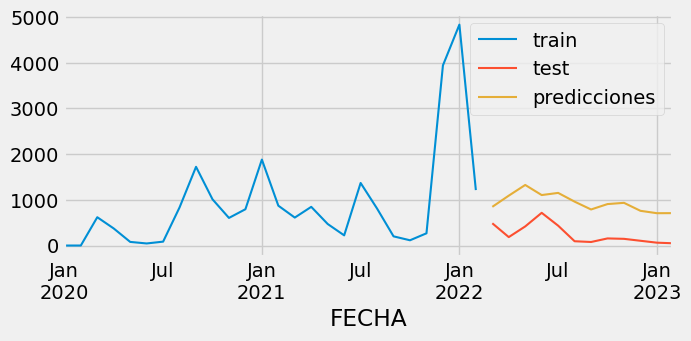

In [98]:
fig, ax = plt.subplots(figsize=(7, 3))
datos_train['TASA_INCIDENCIA'].plot(ax=ax, label='train')
datos_test['TASA_INCIDENCIA'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [99]:
error_mse = metrics.mean_squared_error(
                y_true = datos_test['TASA_INCIDENCIA'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 513700.5641834631


In [100]:
impotancia = forecaster.get_feature_importance()
impotancia

,feature,importance
0,lag_1,0.228270
1,lag_2,0.104027
2,lag_3,0.347007
3,lag_4,0.087836
4,lag_5,0.142001
5,lag_6,0.090859


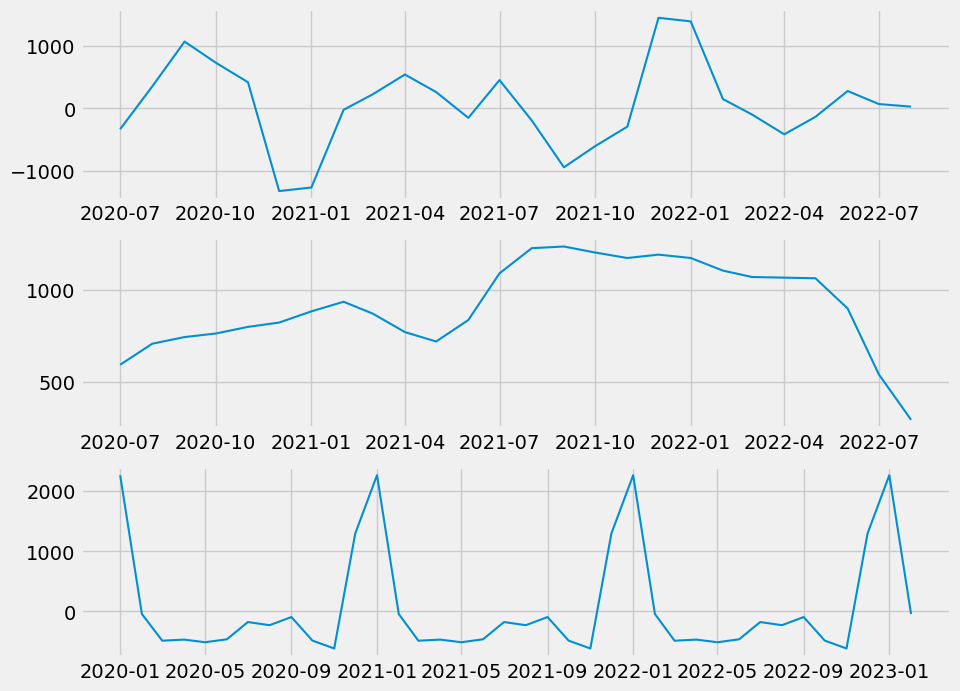

In [199]:
# Ejemplo de descomposición de serie de tiempo #resid, trend, seasonal
import statsmodels.api as sm
descomposicion = sm.tsa.seasonal_decompose(df['TASA_INCIDENCIA'], model='additive')
#plt.figure(figsize=(10,4))
#plt.plot(descomposicion.resid)
#fig = descomposicion.plot()
fig, axs = plt.subplots(3, figsize=(10,8))
axs[0].plot(descomposicion.resid)
#axs[0].set_title('resid')
axs[1].plot(descomposicion.trend)
#axs[1].set_title('trend')
axs[2].plot(descomposicion.seasonal)
#axs[2].set_title('seasonal')
plt.show()

# Ejemplo

In [17]:
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
datos = pd.read_csv(url, sep=',')

In [18]:
# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos.sort_index()
datos.head()

,y,exog_1,exog_2
fecha,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


In [19]:
datos.shape

(195, 3)

Fechas train : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Fechas test  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


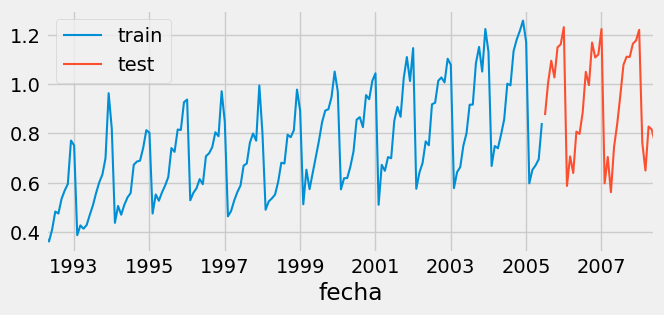

In [20]:
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(7, 3))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
ax.legend();

In [21]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

forecaster.fit(y=datos_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-04-24 19:41:05 
Last fit date: 2023-04-24 19:41:05 
Skforecast version: 0.7.0 
Python version: 3.9.13 
Forecaster id: None 

In [22]:
# Predicciones
# ==============================================================================
steps = 36
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

2005-07-01    0.878756
2005-08-01    0.882167
2005-09-01    0.973184
2005-10-01    0.983678
2005-11-01    0.849494
Freq: MS, Name: pred, dtype: float64

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();
